```
This software is a part of GPU Ocean.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

import datetime

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import glob
import json

#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 300.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
strong_scaling_dir = 'strong_scaling_experiments/'
#strong_scaling_dir = 'strong_scaling_480_particles_experiments/'

weak_scaling_dir = 'weak_scaling_experiments/'

In [3]:
###
### read data from json-files and sort
###

metadata_strong_scaling_filenames = glob.glob(strong_scaling_dir + '/EPS*/EPS*metadata.json')
strong_scaling_filenames = glob.glob(strong_scaling_dir + '/EPS*/EPS*profiling.json')

#print(str(metadata_strong_scaling_filenames))
#print(str(strong_scaling_filenames))

strong_scaling_metadata = [None] * len(metadata_strong_scaling_filenames)
strong_scaling_runs = [None] * len(strong_scaling_filenames)

for i in range(len(strong_scaling_runs)):
    with open(metadata_strong_scaling_filenames[i]) as json_file:
        strong_scaling_metadata[i] = json.load(json_file)
        
    with open(strong_scaling_filenames[i]) as json_file:
        strong_scaling_runs[i] = json.load(json_file)

#print("Before sorting:")
#for i in range(len(strong_scaling_metadata)):
#    #print(strong_scaling_metadata[i]['timestamp'])
#    #print(strong_scaling_metadata[i]['local_ensemble_size'])
#    print(strong_scaling_runs[i]['total'])

zipped_strong_scaling = zip(strong_scaling_metadata, strong_scaling_runs)
zipped_strong_scaling = sorted(zipped_strong_scaling, key=lambda k: k[0]['timestamp'])
strong_scaling_metadata, strong_scaling_runs = zip(*zipped_strong_scaling)

#print("After sorting:")
#for i in range(len(strong_scaling_metadata)):
#    #print(strong_scaling_metadata[i]['timestamp'])
#    #print(strong_scaling_metadata[i]['local_ensemble_size'])
#    print(strong_scaling_runs[i]['total'])


metadata_weak_scaling_filenames = glob.glob(weak_scaling_dir + '/EPS*/EPS*metadata.json')
weak_scaling_filenames = glob.glob(weak_scaling_dir + '/EPS*/EPS*profiling.json')

weak_scaling_metadata = [None] * len(metadata_weak_scaling_filenames)
weak_scaling_runs = [None] * len(weak_scaling_filenames)

for i in range(len(weak_scaling_runs)):
    with open(metadata_weak_scaling_filenames[i]) as json_file:
        weak_scaling_metadata[i] = json.load(json_file)
        
    with open(weak_scaling_filenames[i]) as json_file:
        weak_scaling_runs[i] = json.load(json_file)

zipped_weak_scaling = zip(weak_scaling_metadata, weak_scaling_runs)
zipped_weak_scaling = sorted(zipped_weak_scaling, key=lambda k: k[0]['timestamp'])
weak_scaling_metadata, weak_scaling_runs = zip(*zipped_weak_scaling)

In [4]:
print(strong_scaling_metadata[-1]['num_rank'])

48


In [5]:
###
### extract data for plotting and normalize
###

local_ensemble_sizes = np.empty(len(metadata_strong_scaling_filenames))
num_ranks = np.empty(len(metadata_strong_scaling_filenames))

strong_scaling_times = np.empty(len(strong_scaling_filenames))
strong_scaling_da_times = np.empty(len(strong_scaling_filenames))
strong_scaling_forecast_times = np.empty(len(strong_scaling_filenames))

for i in range(len(strong_scaling_runs)):
    local_ensemble_sizes[i] = strong_scaling_metadata[i]['local_ensemble_size']
    num_ranks[i] = strong_scaling_metadata[i]['num_rank']
    
    strong_scaling_times[i] = strong_scaling_runs[i]['total']
    strong_scaling_da_times[i] = strong_scaling_runs[i]['data_assimilation']
    strong_scaling_forecast_times[i] = strong_scaling_runs[i]['forecast']

# normalize wrt. the single slowest run
#max_strong_scaling_time = max(strong_scaling_times[:])
#strong_scaling_times[:] = strong_scaling_times[:]/max_strong_scaling_time
#strong_scaling_da_times[:] = strong_scaling_da_times[:]/max(strong_scaling_da_times[:])
#strong_scaling_forecast_times[:] = strong_scaling_forecast_times[:]/max(strong_scaling_forecast_times[:])

strong_scaling_speedup = strong_scaling_times[0]/strong_scaling_times[:]
strong_scaling_da_speedup = strong_scaling_da_times[0]/strong_scaling_da_times[:]
strong_scaling_forecast_speedup = strong_scaling_forecast_times[0]/strong_scaling_forecast_times[:]


global_ensemble_sizes = np.empty(len(metadata_weak_scaling_filenames))
num_ranks = np.empty(len(metadata_weak_scaling_filenames))

weak_scaling_times = np.empty(len(weak_scaling_filenames))
weak_scaling_da_times = np.empty(len(weak_scaling_filenames))
weak_scaling_forecast_times = np.empty(len(weak_scaling_filenames))

for i in range(len(weak_scaling_runs)):
    global_ensemble_sizes[i] = weak_scaling_metadata[i]['global_ensemble_size']
    num_ranks[i] = weak_scaling_metadata[i]['num_rank']
    
    weak_scaling_times[i] = weak_scaling_runs[i]['total']
    weak_scaling_da_times[i] = weak_scaling_runs[i]['data_assimilation']
    weak_scaling_forecast_times[i] = weak_scaling_runs[i]['forecast']

# normalize wrt. the single slowest run
#max_weak_scaling_time = max(weak_scaling_times[:])
#weak_scaling_times[:] = weak_scaling_times[:]/max_weak_scaling_time
#weak_scaling_da_times[:] = weak_scaling_da_times[:]/max(weak_scaling_da_times[:])
#weak_scaling_forecast_times[:] = weak_scaling_forecast_times[:]/max(weak_scaling_forecast_times[:])

weak_scaling_speedup = (weak_scaling_times[0]/weak_scaling_times[:])*num_ranks
weak_scaling_da_speedup = (weak_scaling_da_times[0]/weak_scaling_da_times[:])*num_ranks
weak_scaling_forecast_speedup = (weak_scaling_forecast_times[0]/weak_scaling_forecast_times[:])*num_ranks

Text(0, 0.5, 'Speedup factor')

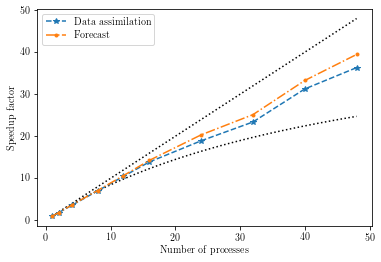

In [6]:
###
### strong scaling plot
###

def theoretic_speed_up(nodes, serial_part):
    return 1 / (serial_part + (1-serial_part) / nodes)

plt.figure()

plt.plot(np.arange(1,49), theoretic_speed_up(np.arange(1,49), 0), 'k:')
plt.plot(np.arange(1,49), theoretic_speed_up(np.arange(1,49), 0.02), 'k:')

#plt.plot(num_ranks,strong_scaling_speedup, marker='*', label='Total')
plt.plot(num_ranks,strong_scaling_da_speedup, '--', marker='*', label='Data assimilation')
plt.plot(num_ranks,strong_scaling_forecast_speedup, '-.', marker='.', label='Forecast')
plt.legend()
#plt.xlim(0,16)
plt.xlabel('Number of processes')
plt.ylabel('Speedup factor')

Text(0, 0.5, 'Scaled speedup factor')

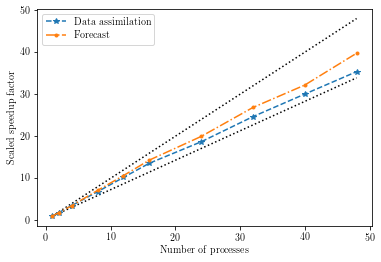

In [7]:
###
### weak scaling plot
###

def scaled_speed_up(nodes, serial_part):
    return serial_part + (1-serial_part) * nodes

plt.figure()

plt.plot(np.arange(1,49), scaled_speed_up(np.arange(1,49), 0), 'k:')
plt.plot(np.arange(1,49), scaled_speed_up(np.arange(1,49), 0.3), 'k:')

#plt.plot(num_ranks,weak_scaling_speedup, marker='*')
plt.plot(num_ranks,weak_scaling_da_speedup, '--', marker='*', label='Data assimilation')
plt.plot(num_ranks,weak_scaling_forecast_speedup, '-.', marker='.', label='Forecast')
plt.legend()

#plt.xlim(0,16)
plt.xlabel('Number of processes')
plt.ylabel('Scaled speedup factor')